<a href="https://colab.research.google.com/github/gaeunkim0721/CNN-Daisy-Dandelion-2021/blob/main/Model_Performance_Evaluations_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
%matplotlib inline

In [84]:
!cp ./drive/MyDrive/Data/Flowers.zip .

In [85]:
!unzip Flowers.zip

Archive:  Flowers.zip
replace Flowers/README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Flowers/README.dataset.txt  
  inflating: Flowers/README.roboflow.txt  
   creating: Flowers/test_data/
  inflating: Flowers/test_data/daisy.10466290366_cc72e33532_jpg.rf.6ddc91cd5d4a6a683e567ccb37e5a089.jpg  
  inflating: Flowers/test_data/daisy.10466558316_a7198b87e2_jpg.rf.7acf642b94dc98daa49482a12994ac4c.jpg  
  inflating: Flowers/test_data/daisy.12193032636_b50ae7db35_n_jpg.rf.e6c4eeb71c56e793a0d85f6d979dbe20.jpg  
  inflating: Flowers/test_data/daisy.1342002397_9503c97b49_jpg.rf.8fe6bdd23186b70f089bb0c5b89d314e.jpg  
  inflating: Flowers/test_data/daisy.1354396826_2868631432_m_jpg.rf.409eee37613d16dbc71365cb5615327e.jpg  
  inflating: Flowers/test_data/daisy.1374193928_a52320eafa_jpg.rf.e398f632151f3ccc5729bc89527d7614.jpg  
  inflating: Flowers/test_data/daisy.1392131677_116ec04751_jpg.rf.da99f9bb579ee96dc1728545ca519d6f.jpg  
  inflating: Flowers/test_data/daisy.143336

In [86]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.models import load_model
#import model_evaluation_utils as meu

In [110]:
tl_cnn = load_model('4-pretrained_cnn_daisy.h5')
tl_img_aug_cnn = load_model('4-2-pre-aug-vgg16_daisy.h5')
tl_img_aug_finetune_cnn = load_model('5-pre-aug-vgg16_Daisy.h5')

In [111]:
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc 


def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
                        

def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions    


def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  codes=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                codes=level_labels)) 
    print(cm_frame) 
    
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
    
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)


def plot_model_decision_surface(clf, train_features, train_labels,
                                plot_step=0.02, cmap=plt.cm.RdYlBu,
                                markers=None, alphas=None, colors=None):
    
    if train_features.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = train_features[:, 0].min() - plot_step, train_features[:, 0].max() + plot_step
    y_min, y_max = train_features[:, 1].min() - plot_step, train_features[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf_est = clone(clf)
    clf_est.fit(train_features,train_labels)
    if hasattr(clf_est, 'predict_proba'):
        Z = clf_est.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf_est.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap)
    
    le = LabelEncoder()
    y_enc = le.fit_transform(train_labels)
    n_classes = len(le.classes_)
    plot_colors = ''.join(colors) if colors else [None] * n_classes
    label_names = le.classes_
    markers = markers if markers else [None] * n_classes
    alphas = alphas if alphas else [None] * n_classes
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_enc == i)
        plt.scatter(train_features[idx, 0], train_features[idx, 1], c=color,
                    label=label_names[i], cmap=cmap, edgecolors='black', 
                    marker=markers[i], alpha=alphas[i])
    plt.legend()
    plt.show()


def plot_model_roc_curve(clf, features, true_labels, label_encoder=None, class_names=None):
    
    ## Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(clf, 'classes_'):
        class_labels = clf.classes_
    elif label_encoder:
        class_labels = label_encoder.classes_
    elif class_names:
        class_labels = class_names
    else:
        raise ValueError('Unable to derive prediction classes, please specify class_names!')
    n_classes = len(class_labels)
    y_test = label_binarize(true_labels, classes=class_labels)
    if n_classes == 2:
        if hasattr(clf, 'predict_proba'):
            prob = clf.predict_proba(features)
            y_score = prob[:, prob.shape[1]-1] 
        elif hasattr(clf, 'decision_function'):
            prob = clf.decision_function(features)
            y_score = prob[:, prob.shape[1]-1]
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")
        
        fpr, tpr, _ = roc_curve(y_test, y_score)      
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
                                 ''.format(roc_auc),
                 linewidth=2.5)
        
    elif n_classes > 2:
        if hasattr(clf, 'predict_proba'):
            y_score = clf.predict_proba(features)
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        ## Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ## Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        ## Plot ROC curves
        plt.figure(figsize=(6, 4))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]), linewidth=3)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]), linewidth=3)

        for i, label in enumerate(class_labels):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                           ''.format(label, roc_auc[i]), 
                     linewidth=2, linestyle=':')
    else:
        raise ValueError('Number of classes should be atleast 2 or more')
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


In [112]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import tensorflow.keras

IMG_DIM = (150, 150)
input_shape = (150, 150, 3)
num2class_label_transformer = lambda l: ['daisy' if x == 0 else 'dandelion' for x in l]
class2num_label_transformer = lambda l: [0 if x == 'daisy' else 1 for x in l]

In [130]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import tensorflow.keras

IMG_DIM = (150, 150)
input_shape = (150, 150, 3)
num2class_label_transformer = lambda l: ['daisy' if x == 0 else 'dandelion' for x in l]
class2num_label_transformer = lambda l: [0 if x == 'daisy' else 1 for x in l]


vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                  input_shape=input_shape)
output = vgg.layers[-1].output
output = tensorflow.keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

def get_bottleneck_features(model, input_imgs):
    
    features = model.predict(input_imgs, verbose=0)
    return features

In [131]:
sample_img_path = 'my_cat.jpg'
sample_img = load_img(sample_img_path, target_size=IMG_DIM)
sample_img_tensor = img_to_array(sample_img)
sample_img_tensor = np.expand_dims(sample_img_tensor, axis=0)
sample_img_tensor /= 255.

print(sample_img_tensor.shape)

(1, 150, 150, 3)


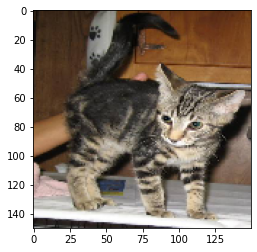

In [94]:
plt.imshow(sample_img_tensor[0])

In [132]:
cnn_prediction = num2class_label_transformer(basic_cnn.predict_classes(sample_img_tensor, verbose=0))
cnn_img_aug_prediction = num2class_label_transformer(img_aug_cnn.predict_classes(sample_img_tensor, verbose=0))
tlearn_cnn_prediction = num2class_label_transformer(tl_cnn.predict_classes(get_bottleneck_features(vgg_model, 
                                                                                                    sample_img_tensor), 
                                                                           verbose=0))
tlearn_cnn_img_aug_prediction = num2class_label_transformer(tl_img_aug_cnn.predict_classes(sample_img_tensor, verbose=0))
tlearn_cnn_finetune_img_aug_prediction = num2class_label_transformer(tl_img_aug_finetune_cnn.predict_classes(sample_img_tensor, 
                                                                                                         verbose=0))

print('Predictions for our sample image:\n', 
      '\nBasic CNN:', cnn_prediction, 
      '\nCNN with Img Augmentation:', cnn_img_aug_prediction, 
      '\nPre-trained CNN (Transfer Learning):', tlearn_cnn_prediction,
      '\nPre-trained CNN with Img Augmentation (Transfer Learning):', tlearn_cnn_img_aug_prediction, 
      '\nPre-trained CNN with Fine-tuning & Img Augmentation (Transfer Learning):', tlearn_cnn_finetune_img_aug_prediction)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Predictions for our sample image:
 
Basic CNN: ['daisy'] 
CNN with Img Augmentation: ['daisy'] 
Pre-trained CNN (Transfer Learning): ['dandelion'] 
Pre-trained CNN with Img Augmentation (Transfer Learning): ['dandelion'] 
Pre-trained CNN with Fine-tuning & Img Augmentation (Transfer Learning): ['daisy']


In [133]:
print('Predictions for our sample image:\n', cnn_prediction)

Predictions for our sample image:
 ['daisy']


In [134]:
tl_img_aug_finetune_cnn.layers[0].layers[1:9]

In [135]:
from tensorflow.keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in tl_img_aug_finetune_cnn.layers[0].layers[1:9]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=tl_img_aug_finetune_cnn.layers[0].layers[1].input, outputs=layer_outputs)
# This will return a list of 8 Numpy array
# one array per layer activation
activations = activation_model.predict(sample_img_tensor)

In [136]:
print ('Sample layer shape:', activations[0].shape)
print('Sample convolution (activation map) shape:', activations[0][0, :, :, 1].shape)

Sample layer shape: (1, 150, 150, 64)
Sample convolution (activation map) shape: (150, 150)


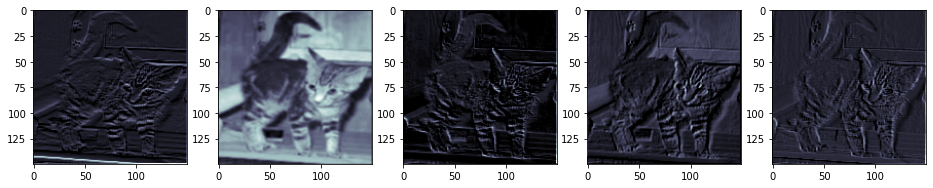

In [137]:
fig, ax = plt.subplots(1,5, figsize=(16, 6))
ax[0].imshow(activations[0][0, :, :, 10], cmap='bone')
ax[1].imshow(activations[0][0, :, :, 25], cmap='bone')
ax[2].imshow(activations[0][0, :, :, 40], cmap='bone')
ax[3].imshow(activations[0][0, :, :, 55], cmap='bone')
ax[4].imshow(activations[0][0, :, :, 63], cmap='bone')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


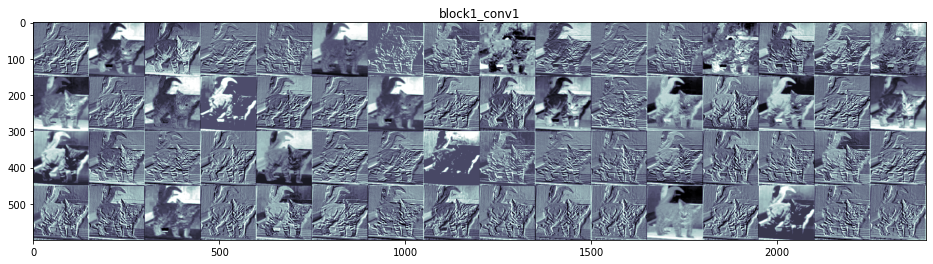

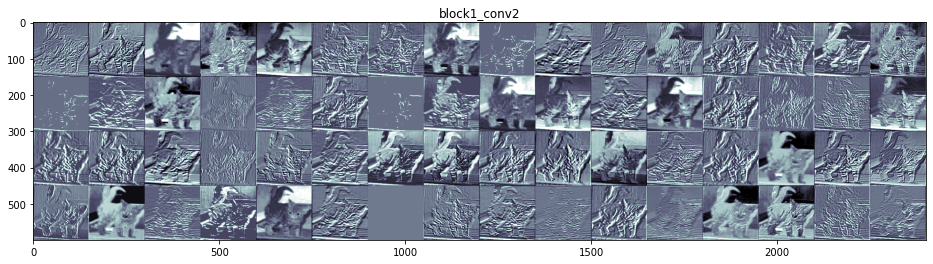

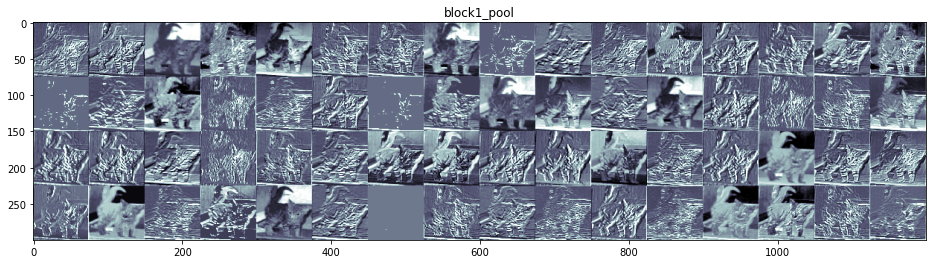

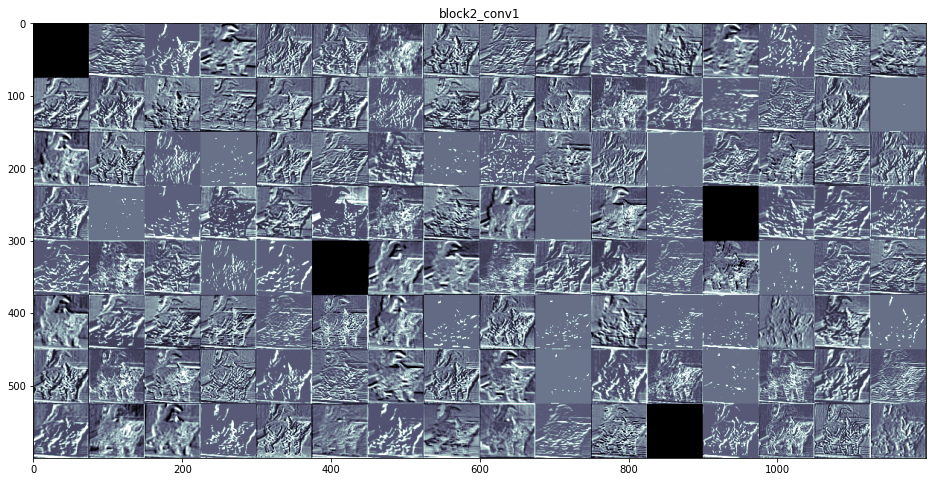

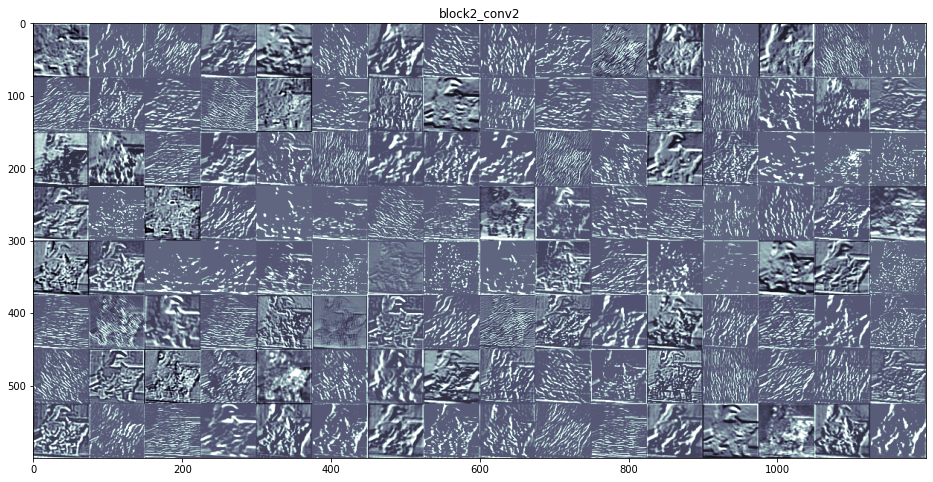

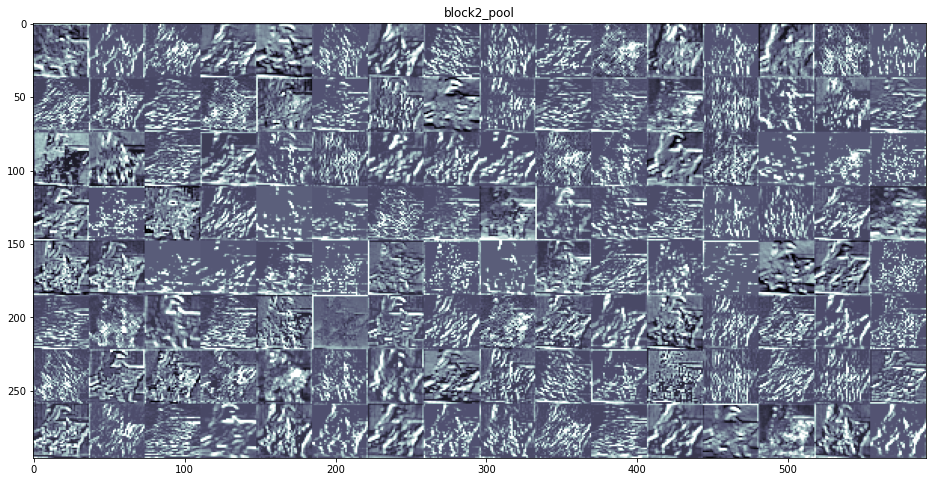

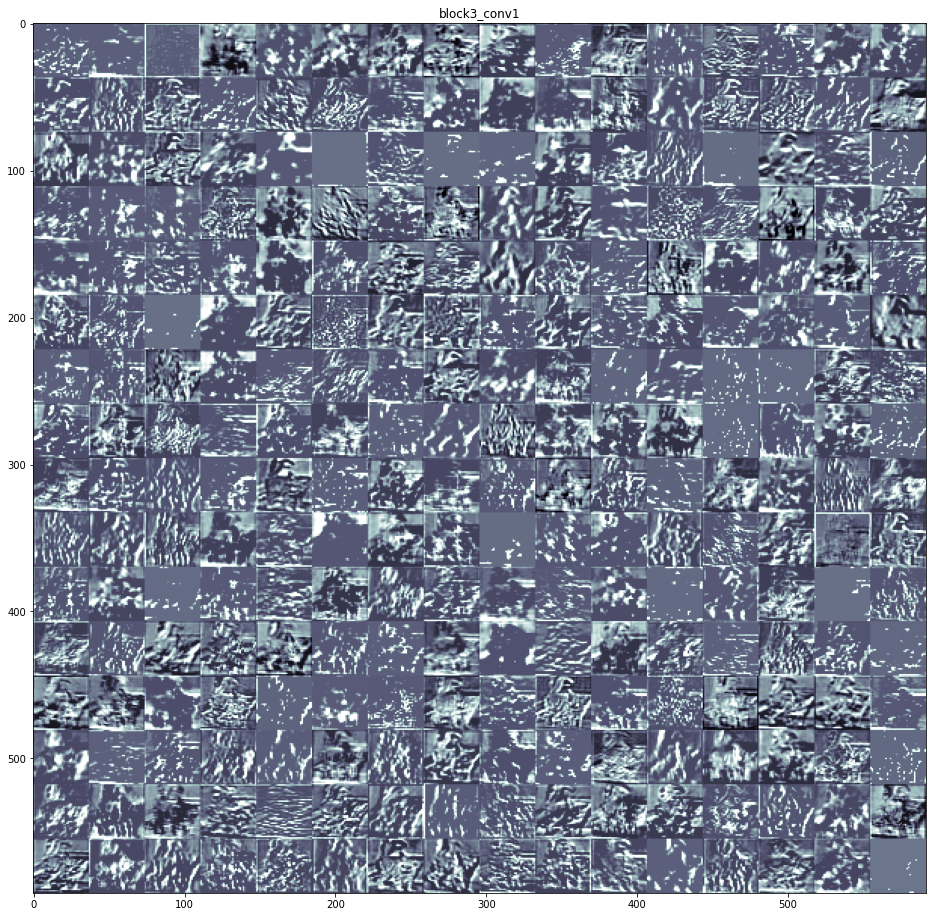

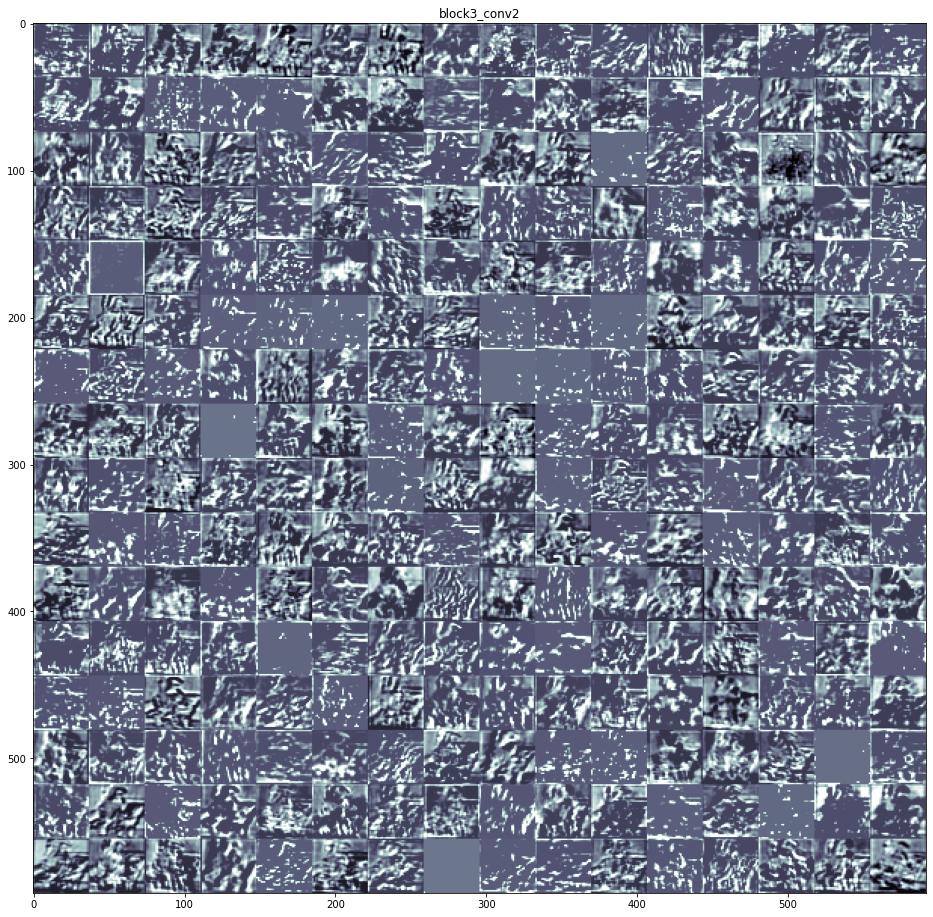

In [138]:
import tensorflow.keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in tl_img_aug_finetune_cnn.layers[0].layers[1:9]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='bone')

In [139]:
IMG_DIM = (150, 150)

test_files = glob.glob('test_data/*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('/')[1].split('.')[0].strip() for fn in test_files]

print('Test dataset shape:', test_imgs.shape)

Test dataset shape: (182, 150, 150, 3)


In [140]:
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

test_labels_enc = class2num_label_transformer(test_labels)

print(test_labels[0:5], test_labels_enc[0:5])

['dandelion', 'dandelion', 'dandelion', 'dandelion', 'dandelion'] [1, 1, 1, 1, 1]


In [141]:
list(set(test_labels))

['daisy', 'dandelion']

In [142]:
predictions = basic_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)

display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.467
Precision: 0.4936
Recall: 0.467
F1 Score: 0.4644

Model Classification report:
------------------------------
              precision    recall  f1-score   support

       daisy       0.41      0.58      0.48        77
   dandelion       0.56      0.38      0.45       105

    accuracy                           0.47       182
   macro avg       0.48      0.48      0.47       182
weighted avg       0.49      0.47      0.46       182


Prediction Confusion Matrix:
------------------------------
                  Predicted:          
                       daisy dandelion
Actual: daisy             45        32
        dandelion         65        40


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [143]:
predictions = img_aug_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)

display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.5165
Precision: 0.5024
Recall: 0.5165
F1 Score: 0.5056

Model Classification report:
------------------------------
              precision    recall  f1-score   support

       daisy       0.41      0.32      0.36        77
   dandelion       0.57      0.66      0.61       105

    accuracy                           0.52       182
   macro avg       0.49      0.49      0.49       182
weighted avg       0.50      0.52      0.51       182


Prediction Confusion Matrix:
------------------------------
                  Predicted:          
                       daisy dandelion
Actual: daisy             25        52
        dandelion         36        69


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [144]:
test_bottleneck_features = get_bottleneck_features(vgg_model, test_imgs_scaled)

predictions = tl_cnn.predict_classes(test_bottleneck_features, verbose=0)
predictions = num2class_label_transformer(predictions)

display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.8791
Precision: 0.879
Recall: 0.8791
F1 Score: 0.8786

Model Classification report:
------------------------------
              precision    recall  f1-score   support

       daisy       0.88      0.83      0.85        77
   dandelion       0.88      0.91      0.90       105

    accuracy                           0.88       182
   macro avg       0.88      0.87      0.88       182
weighted avg       0.88      0.88      0.88       182


Prediction Confusion Matrix:
------------------------------
                  Predicted:          
                       daisy dandelion
Actual: daisy             64        13
        dandelion          9        96


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [145]:
predictions = tl_img_aug_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)

display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, classes=list(set(test_labels)))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Model Performance metrics:
------------------------------
Accuracy: 0.7033
Precision: 0.733
Recall: 0.7033
F1 Score: 0.675

Model Classification report:
------------------------------
              precision    recall  f1-score   support

       daisy       0.81      0.39      0.53        77
   dandelion       0.68      0.93      0.78       105

    accuracy                           0.70       182
   macro avg       0.74      0.66      0.66       182
weighted avg       0.73      0.70      0.67       182


Prediction Confusion Matrix:
------------------------------
                  Predicted:          
                       daisy dandelion
Actual: daisy             30        47
        dandelion          7        98


In [146]:
predictions = tl_img_aug_finetune_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)

display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Model Performance metrics:
------------------------------
Accuracy: 0.7802
Precision: 0.7896
Recall: 0.7802
F1 Score: 0.7815

Model Classification report:
------------------------------
              precision    recall  f1-score   support

       daisy       0.71      0.82      0.76        77
   dandelion       0.85      0.75      0.80       105

    accuracy                           0.78       182
   macro avg       0.78      0.79      0.78       182
weighted avg       0.79      0.78      0.78       182


Prediction Confusion Matrix:
------------------------------
                  Predicted:          
                       daisy dandelion
Actual: daisy             63        14
        dandelion         26        79


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


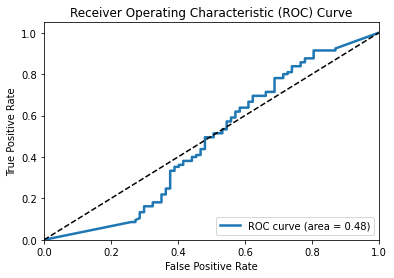

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


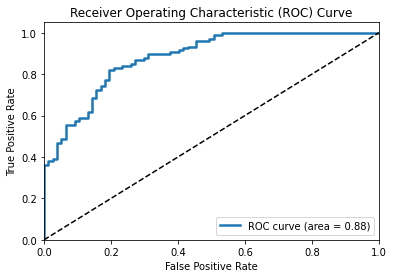

In [147]:
plot_model_roc_curve(basic_cnn, test_imgs_scaled, 
                                  true_labels=test_labels_enc, class_names=[0, 1])

plot_model_roc_curve(tl_img_aug_finetune_cnn, test_imgs_scaled, 
                                  true_labels=test_labels_enc, class_names=[0, 1])